In [10]:
import pandas as pd
import numpy as np

In [11]:
import logging
logging_fmt = '%(asctime)s:%(name)s:%(levelname)s:%(message)s'
logging.basicConfig(level=logging.INFO, format=logging_fmt)

In [12]:
import matplotlib.pyplot as plt

In [13]:
from calibrate_util import *

cal_vecs = {}

In [14]:
def cal_axis(port_p, axis_name, cols, vec_dict):
    df = data_input_main(port_p, None, period=10)
    df_cols = df.loc[:,cols]
    vec_dict[axis_name] = np.asarray(df_cols.mean())

In [53]:
cal_axis("/dev/tty.usbmodem141201", "+y", ["xAcc", "yAcc", "zAcc"], )

2022-07-26 10:29:02,653:root:INFO:Starting thread 1
2022-07-26 10:29:08,957:root:INFO:1658856548.95763
2022-07-26 10:29:18,985:root:INFO:Exiting thread 1
2022-07-26 10:29:19,042:root:INFO:Closing threads
2022-07-26 10:29:19,063:root:INFO:Threads successfully closed


In [64]:
cal_vecs

{'+z': array([ 0.01856622, -0.0116973 ,  0.99432365]),
 '-z': array([-0.03777517,  0.01634295, -1.01690067]),
 '+x': array([ 0.99453987,  0.00569051, -0.02933165]),
 '-x': array([-1.00537417,  0.0015404 , -0.03978742]),
 '-y': array([-0.00619732, -1.00584027, -0.01612081]),
 '+y': array([-0.00161879,  0.99356309, -0.00426846])}

In [26]:
from sklearn import linear_model

In [27]:
def axis_to_idx(axis):
    if (axis == "x"):
        return 0
    if (axis == "y"):
        return 1
    if (axis == "z"):
        return 2
    return None

def ideal_vec(axis, val):
    arr = np.zeros(3)
    arr[axis_to_idx(axis)] = val
    return arr
        
def prep_fit_data(data):
    X = []
    y = []
    
    for key in data:
        if key[0] == "-":
            y.append(ideal_vec(key[1], -1))
        if key[0] == "+":
            y.append(ideal_vec(key[1], 1))
        X.append(data[key])
    return X, y

In [120]:
X,y = prep_fit_data(cal_vecs)
logging.info(X)
logging.info(y)

2022-07-26 11:21:54,104:root:INFO:[array([ 0.01856622, -0.0116973 ,  0.99432365]), array([-0.03777517,  0.01634295, -1.01690067]), array([ 0.99453987,  0.00569051, -0.02933165]), array([-1.00537417,  0.0015404 , -0.03978742]), array([-0.00619732, -1.00584027, -0.01612081]), array([-0.00161879,  0.99356309, -0.00426846])]
2022-07-26 11:21:54,108:root:INFO:[array([0., 0., 1.]), array([ 0.,  0., -1.]), array([1., 0., 0.]), array([-1.,  0.,  0.]), array([ 0., -1.,  0.]), array([0., 1., 0.])]


In [121]:
mod = linear_model.LinearRegression()
mod.fit(X, y)

LinearRegression()

In [122]:
mod.coef_

array([[ 1.00017503, -0.0021071 , -0.02801951],
       [-0.00213201,  1.00016603,  0.01409015],
       [-0.00515688, -0.00579448,  0.99410919]])

In [123]:
mod.intercept_

array([0.00578743, 0.00031655, 0.01853792])

In [126]:
mod.predict([[1, 1, 1]])

array([[0.97583585, 1.01244072, 1.00169575]])

In [15]:
from scipy import integrate

In [18]:
port_p = "/dev/tty.usbmodem141201"
coeff_fp = "acc_coeff.csv"
intercept_fp = "acc_intercept.csv"

2022-08-08 14:03:24,528:root:INFO:coef: [[ 1.00103165 -0.01318028 -0.01898536]
 [-0.00395815  1.00045559  0.0141501 ]
 [ 0.01764022 -0.00476623  0.99522451]]
2022-08-08 14:03:24,539:root:INFO:intercept: [0.00749475 0.00897139 0.01676315]
2022-08-08 14:03:25,576:root:INFO:Starting thread 1


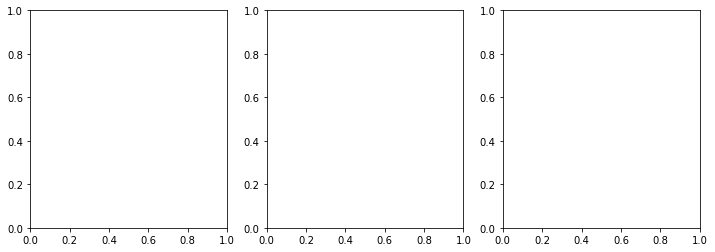

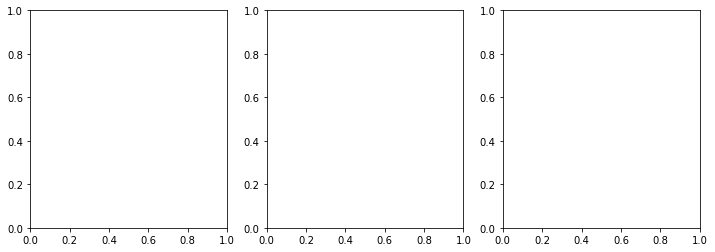

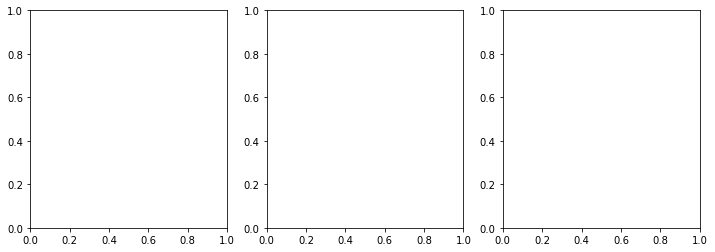

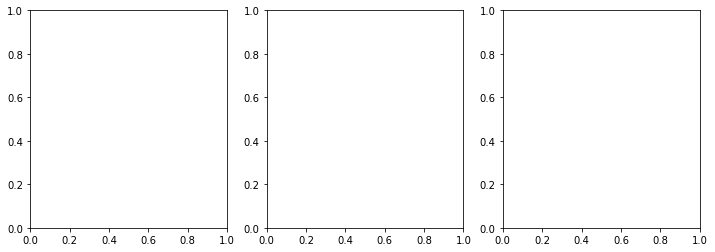

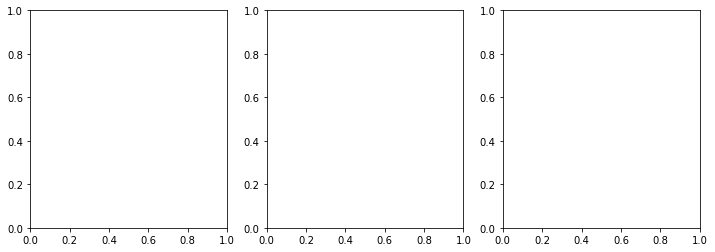

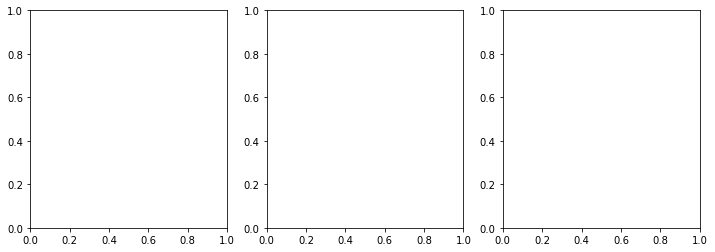

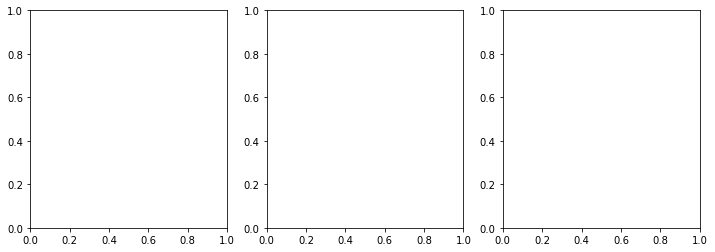

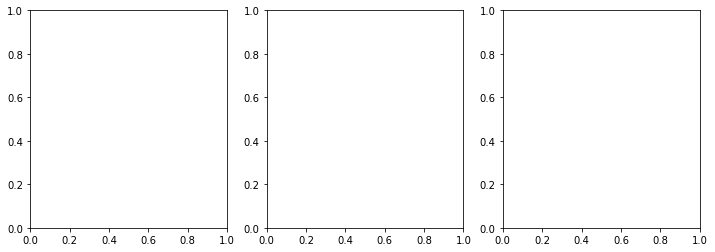

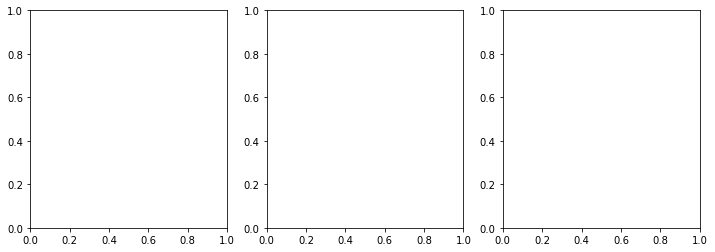

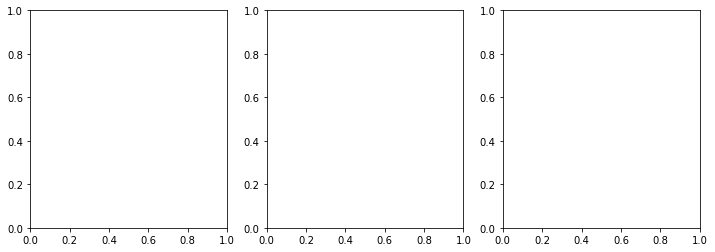

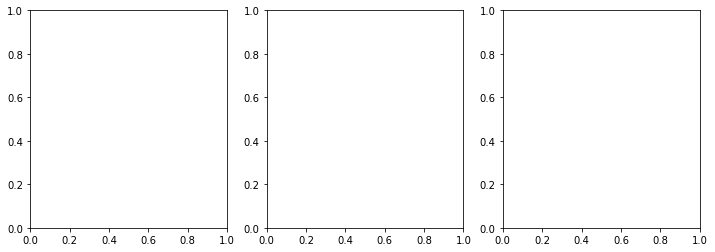

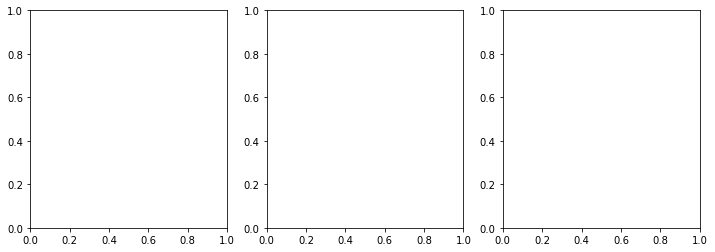

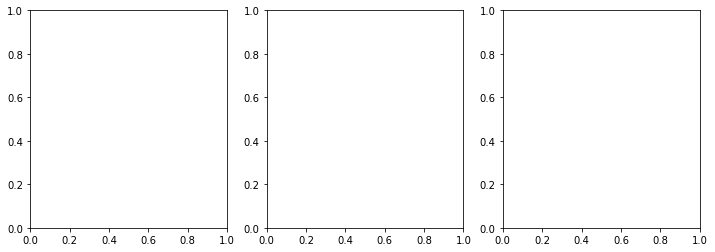

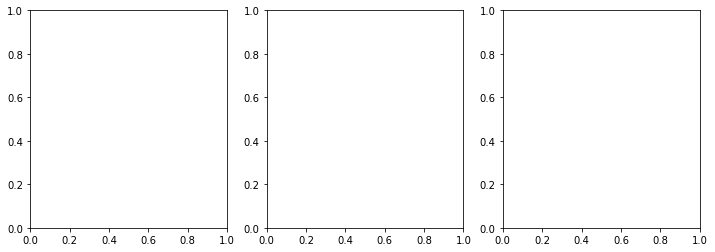

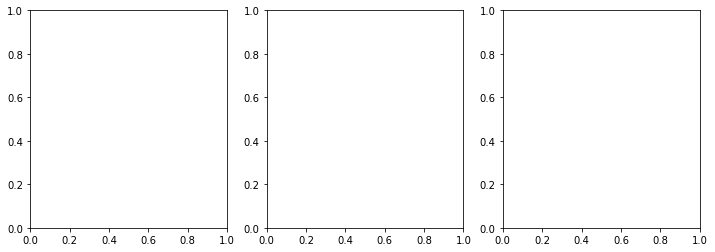

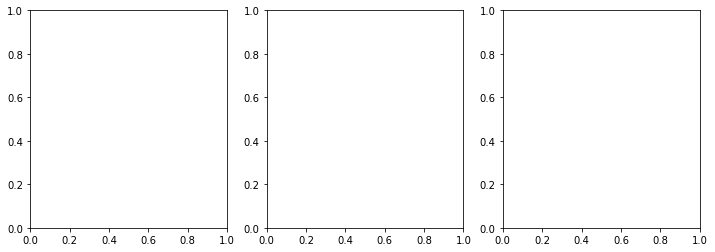

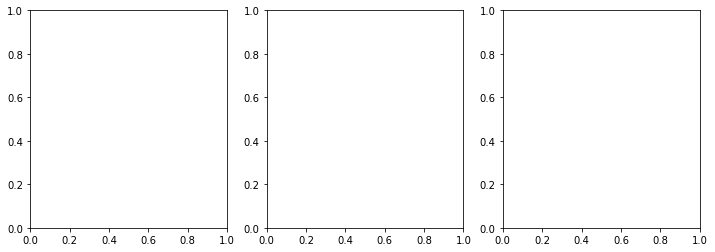

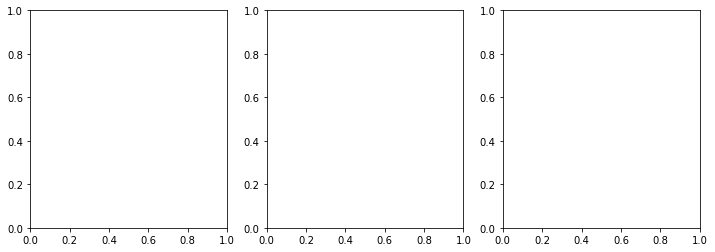

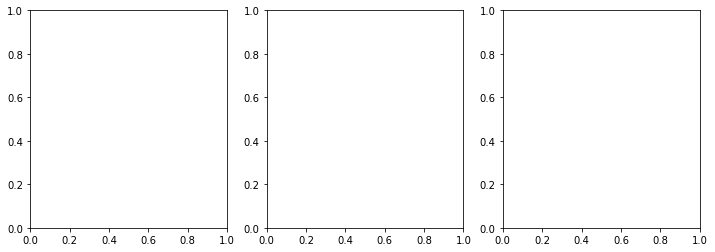

2022-08-08 14:03:32,835:root:INFO:1659992612.835733


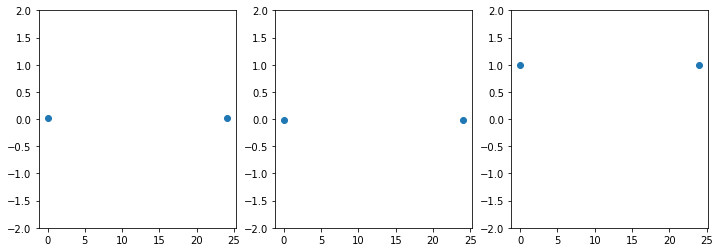

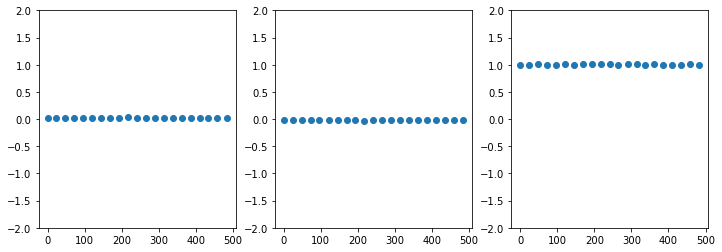

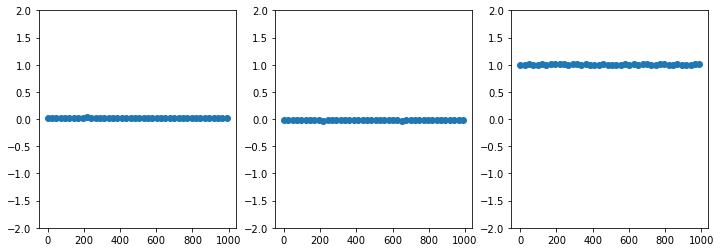

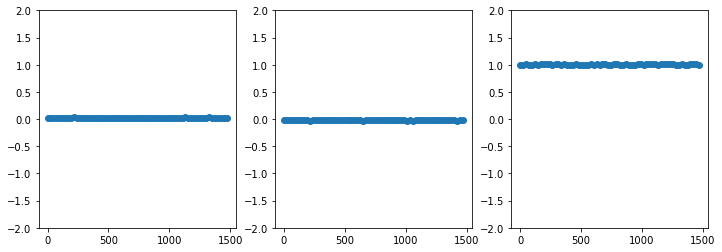

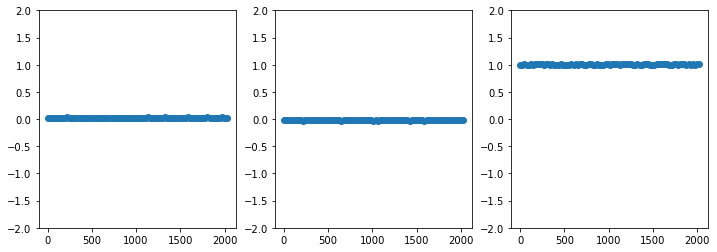

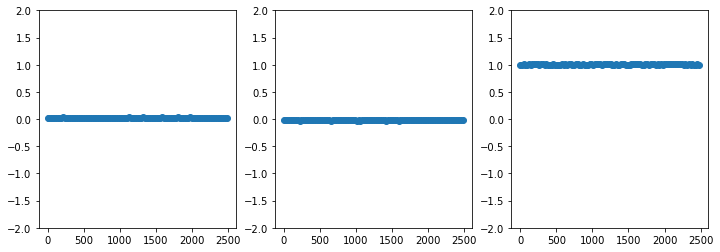

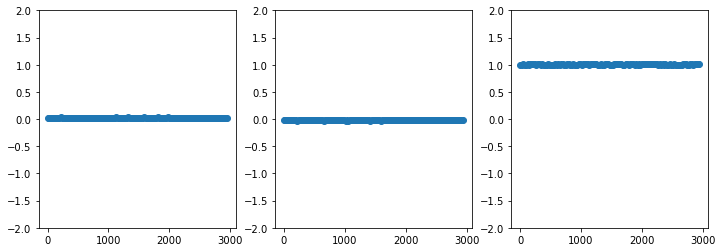

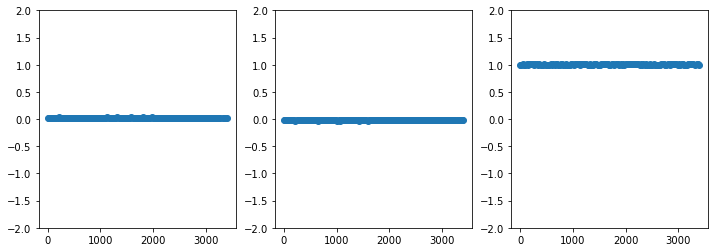

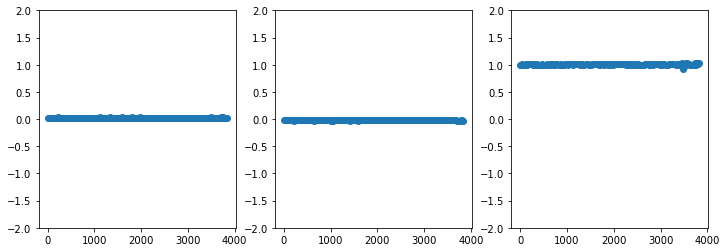

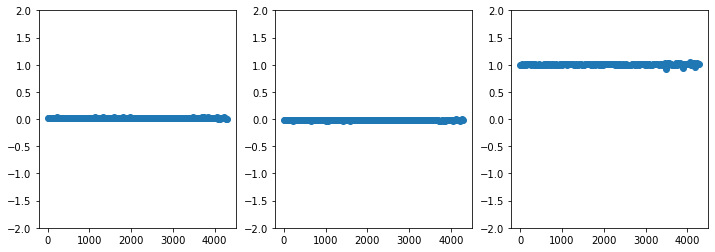

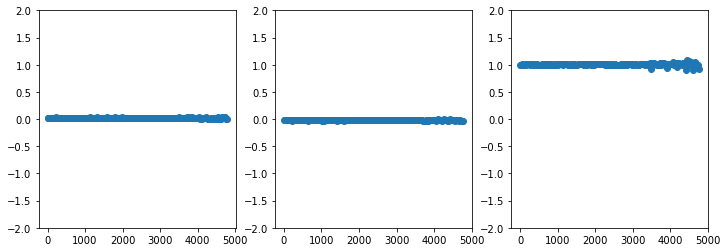

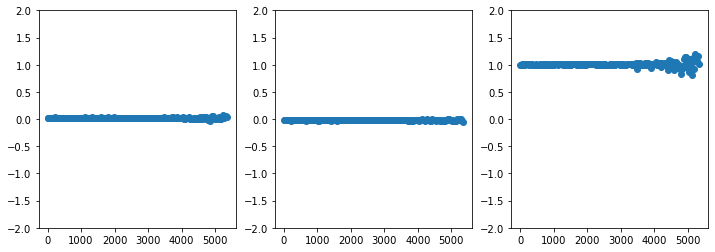

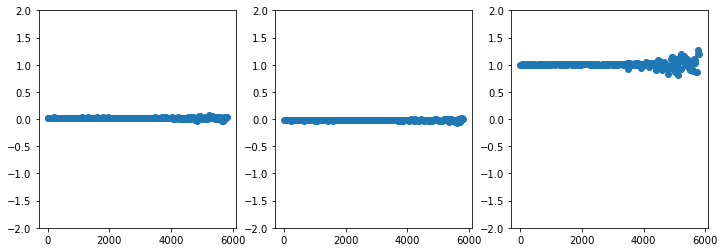

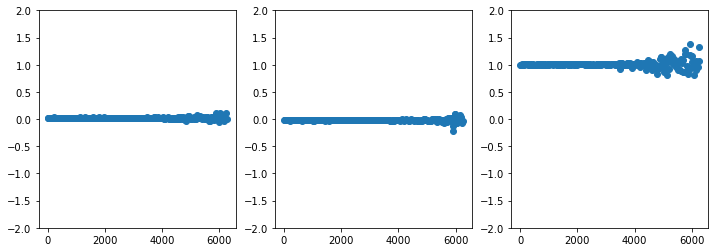

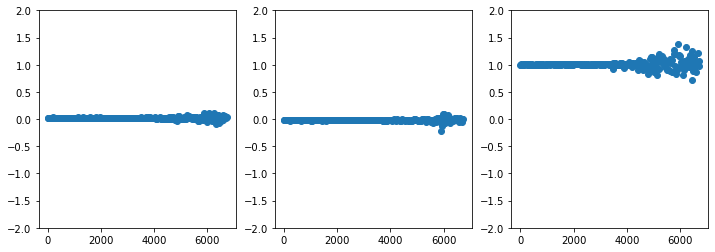

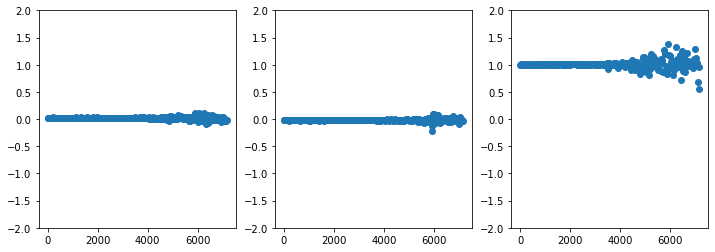

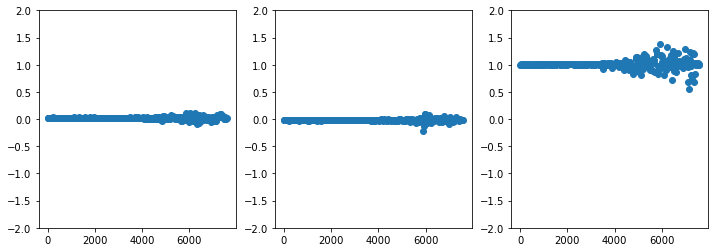

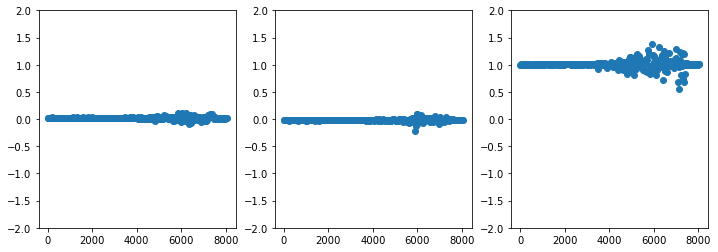

2022-08-08 14:03:41,716:root:INFO:Closing threads
2022-08-08 14:03:41,718:root:INFO:Exiting thread 1
2022-08-08 14:03:41,749:root:INFO:Threads successfully closed


In [24]:
coeff_ = np.loadtxt(open(coeff_fp, "rb"), delimiter=",", skiprows=0)
intercept_ = np.loadtxt(open(intercept_fp, "rb"), delimiter=",", skiprows=0)
logging.info("coef: {}".format(coeff_))
logging.info("intercept: {}".format(intercept_))

df = data_input_main(port_p, plot_accelerometer, period=None)
acc_arr = df.loc[:,["xAcc", "yAcc", "zAcc"]].to_numpy()

x = df.loc[:,"time"].to_numpy()

In [28]:
mod = linear_model.LinearRegression()
mod.coef_ = coeff_
mod.intercept_ = intercept_

y_hat = mod.predict(acc_arr)
np.average(y_hat[:,0])

0.009149432656257537

In [29]:
x = (x-x[0])/1000

In [31]:
delta_v = integrate.cumtrapz(9.8 * y_hat[:,0], x)


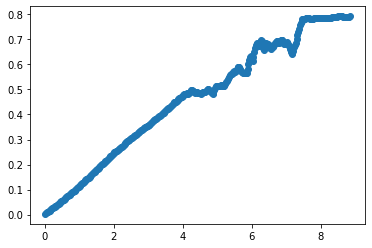

In [32]:
plt.scatter(x[1:], delta_v)

In [36]:
delta_x = integrate.cumtrapz(delta_v, x[1:])
delta_x[-1]
x.shape

(365,)

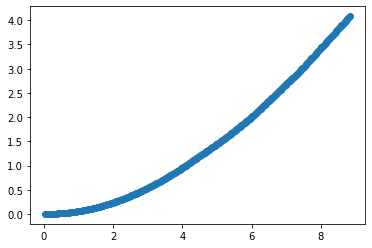

In [37]:
plt.scatter(x[2:],delta_x)

Storing and sending calibration coefficients to fin

In [2]:
test_num = 5.42908729374

In [3]:
import struct
def float_to_bin(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

def bin_to_float(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

In [17]:
bin_str = float_to_bin(test_num)
bin_str

'01000000101011011011101100010101'

In [18]:
uint32 = int(bin_str, 2)
uint32

1085127445

In [19]:
bin_str == (bin(uint32)[2:]).zfill(32)

True

In [5]:
import pandas as pd
import numpy as np
from argparse import ArgumentParser
import json
import ctypes

from sklearn import linear_model
from scipy import integrate
import matplotlib.pyplot as plt

from cli_util import drop_into_cli

from calibrate_util import *

import logging
logging_fmt = '%(asctime)s:%(name)s:%(levelname)s:%(message)s'
logging.basicConfig(level=logging.INFO, format=logging_fmt)

axii = ["+x", "-x", "+y", "-y", "+z", "-z"]
CAL_PERIOD = 10
CAL_VAL_FREQ = 5

ACC_COLS = ["xAcc", "yAcc", "zAcc"]
GYRO_COLS = ["xAng", "yAng", "zAng"]
MAG_COLS = ["xMag", "yMag", "zMag"]

ACC_COLS_SI = ["X Acceleration", "Y Acceleration", "Z Acceleration"]
GYRO_COLS_SI = ["X Angular Velocity", "Y Angular Velocity", "Z Angular Velocity"]
MAG_COLS_SI = ["X Angular Velocity", "Y Angular Velocity", "Z Angular Velocity"]
THERMAL_COLS_SI = ["Temperature"]

THERMAL_COLS = ["temp"]

SENSORS = {"acc": ACC_COLS_SI, "mag": MAG_COLS_SI, "thermal": THERMAL_COLS_SI}

CAL_COEFFS = ["gyro_intercept", "acc_coeff", "acc_intercept", "mag_coeff", "mag_intercept", "thermal_coeff", "thermal_intercept"]

In [6]:
def apply_cal(input_dir, df_data):
    cal_data_dict = load_cal(input_dir)
    apply_cal_sensor("acc", SENSORS["acc"], cal_data_dict, df_data)
    
def apply_cal_sensor(sensor_name, sensor_cols, cal_data_dict, df_data):
    coeff_key = "{}_coeff".format(sensor_name)
    intercept_key = "{}_intercept".format(sensor_name)
    if coeff_key not in cal_data_dict and intercept_key not in cal_data_dict:
        return None
    
    mod = linear_model.LinearRegression()
    mod.coef_ = csv_str_to_arr(cal_data_dict[coeff_key])
    mod.intercept_ = csv_str_to_arr(cal_data_dict[intercept_key]).flatten() #might not work because all arrays are 2D
    
    np_uncal_data = df_data.loc[:,sensor_cols].to_numpy()
    logging.info(np_uncal_data)
    
    logging.info("calibrated data shape: {}".format(np_cal_data.shape))
    logging.info("calibrated data: {}".format(np_cal_data))

In [62]:
df = pd.read_csv("_200047001750483553353920-20220728-201824-session-data.csv")
#apply_cal("calibrations.json", df)
df

,temp+water,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,xMag,yMag,zMag,...,Water Detect,X Acceleration,Y Acceleration,Z Acceleration,X Angular Velocity,Y Angular Velocity,Z Angular Velocity,X Magnetic Field,Y Magnetic Field,Z Magnetic Field
0,2779.0,-1892.0,18328.0,-164.0,-955.0,1649.0,1315.0,28160.0,25088.0,-27906.0,...,True,-0.115479,1.118652,-0.010010,-7.286072,12.580872,10.032654,4224.0,3763.2,-4185.9
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2779.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2779.0,-1724.0,18732.0,1760.0,497.0,1659.0,1174.0,23808.0,27136.0,-29186.0,...,True,-0.105225,1.143311,0.107422,3.791809,12.657166,8.956909,3571.2,4070.4,-4377.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.0,2136.0,-16044.0,-2196.0,184.0,12.0,47.0,-10496.0,21758.0,-6658.0,...,True,0.130371,-0.979248,-0.134033,1.403809,0.091553,0.358582,-1574.4,3263.7,-998.7
1849,0.0,2064.0,-16040.0,-2228.0,168.0,45.0,61.0,-12032.0,19454.0,-8194.0,...,True,0.125977,-0.979004,-0.135986,1.281738,0.343323,0.465393,-1804.8,2918.1,-1229.1
1850,0.0,1960.0,-15828.0,-2324.0,366.0,213.0,39.0,-13312.0,22526.0,-7170.0,...,True,0.119629,-0.966064,-0.141846,2.792358,1.625061,0.297546,-1996.8,3378.9,-1075.5
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
cal_dict = load_cal("calibrations.json")
sensor_name = "acc"
sensor_cols = SENSORS["acc"]

coeff_key = "{}_coeff".format(sensor_name)
intercept_key = "{}_intercept".format(sensor_name)

coeff = csv_str_to_arr(cal_dict[coeff_key])
intercept = csv_str_to_arr(cal_dict[intercept_key]).flatten()

In [26]:
mod = linear_model.LinearRegression()
mod.coef_ = coeff
mod.intercept_ = intercept

In [54]:
msk = ~df.loc[:,sensor_cols].isna().any(axis=1)
msk.sum()

1682

In [61]:
yhat = np.full(df.loc[:,sensor_cols].shape, np.nan)
pred = pd.DataFrame(mod.predict(df.loc[:,sensor_cols][msk]))
yhat[msk.astype(bool), ...] = pred
yhat

/Users/allenyang/opt/anaconda3/envs/smartfin/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([[-1.22657011e-01,  1.12844882e+00, -5.67634871e-04],
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       ...,
       [ 1.42673063e-01, -9.60013832e-01, -1.17690405e-01],
       [            nan,             nan,             nan],
       [ 1.46836971e-01, -9.68743871e-01, -1.11986881e-01]])

In [58]:
pd.DataFrame(mod.predict(df.loc[:,sensor_cols].dropna()))


/Users/allenyang/opt/anaconda3/envs/smartfin/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,0,1,2
0,-0.122657,1.128449,-0.000568
1,-0.114947,1.154739,0.116367
2,-0.096855,0.943892,-0.020424
3,-0.145106,1.043198,0.044149
4,0.040068,0.972629,-0.106622
...,...,...,...
1677,0.148879,-0.810770,0.057240
1678,0.153452,-0.973135,-0.109663
1679,0.149087,-0.972901,-0.111685
1680,0.142673,-0.960014,-0.117690


In [71]:
import decoder as scd

ensembles = []
with open("2f0019000f47373333353132-000000_temp_00.sfr", 'r') as sfr:
    for record in sfr:
        ensembles.extend(scd.decodeRecord(record.strip()))
        
df = pd.DataFrame(ensembles)

In [72]:
df

,temp+water,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,xMag,yMag,zMag,timestamp,dataType
0,2827,508,-240,16096,-102,19,-120,-1,-1,-1,1.3,10


In [68]:
from calibrate import cal_board_set

In [70]:
cal_board_set("/dev/tty.usbmodem141201", "calibrations.json")

2022-08-12 11:27:45,549:root:INFO:[ 1.00103165 -0.01318028 -0.01898536 -0.00395815  1.00045559  0.0141501
  0.01764022 -0.00476623  0.99522451]
2022-08-12 11:27:45,564:root:INFO:{'gyro_intercept': [3214018847, 3190075136, 3196524531], 'acc_coeff': [1065361870, 3159880218, 3164309296, 3145839454, 1065357038, 1013437906, 1016103481, 3147574793, 1065273097], 'acc_intercept': [1005950597, 1007877309, 1015632608], 'mag_coeff': [1071168582, 3165977344, 1017557049, 3165977344, 1072198111, 1033894009, 1017557049, 1033894009, 1072992053], 'mag_intercept': [3286457279, 1126795995, 3241386306], 'thermal_coeff': [1065624950], 'thermal_intercept': [3210609964]}
2022-08-12 11:27:45,566:root:INFO:keys: dict_keys(['gyro_intercept', 'acc_coeff', 'acc_intercept', 'mag_coeff', 'mag_intercept', 'thermal_coeff', 'thermal_intercept'])


~
press enter to start

gyro_intercept
3214018847
3190075136
3196524531

acc_coeff
1065361870
3159880218
3164309296
3145839454
1065357038
1013437906
1016103481
3147574793
1065273097

acc_intercept
1005950597
1007877309
1015632608

mag_coeff
1071168582
3165977344
1017557049
3165977344
1072198111
1033894009
1017557049
1033894009
1072992053

mag_intercept
3286457279
1126795995
3241386306

thermal_coeff
1065624950

thermal_intercept
3210609964
calibration coefficients loaded successfully
>
Unknown command
